In [1]:
sc

In [2]:
import time

In [3]:
start_time = time.time()
print sc.textFile("/data/all-pages-indexed-out.txt").map(lambda x: 1).reduce(lambda x, y: x + y)
print "Time taken: " + str(time.time() - start_time)

5781290
Time taken: 24.968583107


In [4]:
start_time = time.time()
print sc.textFile("/data/all-pages-indexed-out.txt").map(lambda x: 1).reduce(lambda x, y: x + y)
print "Time taken: " + str(time.time() - start_time)

5781290
Time taken: 9.1845138073


In [4]:
# mapCount is for counting the true number of nodes
# necessary since nodes with no outgoing links are not listed on their own line

def mapCount(entry):
    yield (str(entry[0]), 1)
    for key, value in entry[1].items():
        yield (key, 1)
        
# processLine turns the string into python objects,
# specifically the label and a dictionary of edges.
# this assumes zero formatting errors
def processLine(line):
    splits = line.strip().split('\t')
    return [splits[0], eval(splits[1])]

# prep_map generates a line for each possible node, including nodes that exist
# only in the edge dictionary of another node
def prep_map(entry):
    nodeID = entry[0]
    edges = entry[1]
    for edge, weight in edges.items():
        yield (str(edge.strip()), {})
    yield (str(nodeID), edges)
    
# prep_reduce combines the dictionaries of the records created in the map phase
def prep_reduce(x, y):
    edges = {}
    for key, value in x.items():
        edges[key] = value
    for key, value in y.items():
        edges[key] = value
    return edges

# init_entry distributes the initial probability mass
# it also adds a value into the record of 0.0 which will eventually represent
# the amount of change in that node's probability mass
# which we'll use to check for convergence
# it is reliant on the accum_total_pr accumulator for its closure

accum_total_pr = sc.accumulator(0.0)

def init_entry(entry):
    accum_total_pr.add(1.0 / broadcast_nodecount.value)
    return (entry[0], [entry[1], 1.0 / broadcast_nodecount.value, 0.0]) #the 0.0 is the delta pr 


# Phase one consists of a map and reducebykey phase.
# phaseOneMapper stores the pr mass of the node as it is as the beginning of the step
# if there are no outgoing edges, it passes all the pr mass of that node to the dangling_mass accumulator
# which is defined here for the closure.
# if there are edges, it divides the pr mass evenly among them and emits the target node with 
# an empty edge list and a zero previous pr mass.  This is done so that when records are combined
# in the reduce step, there will be exactly one record with a full edge list and an accurate
# previous pr mass, so we can cummutatively and associatively add the records together
# and arrive at a single accurate record

accum_dangling_mass = sc.accumulator(0.0)


def phaseOneMapper(entry):
    label = entry[0]
    edges = entry[1][0]
    pr = entry[1][1]
    previous = pr

    if len(edges) == 0:
        accum_dangling_mass.add(pr)
    else:
        forwarding_pr = pr / len(edges)
        for edge, weight in edges.items():
            yield (edge, [{}, forwarding_pr, 0.0])
    yield (label, [edges, 0.0, pr])

def phaseOneReducer(x, y):
    edges = {}
    for edge, weight in x[0].items():
        edges[edge] = weight
    for edge, weight in y[0].items():
        edges[edge] = weight
    return [edges, x[1] + y[1], x[2] + y[2]]

# the finalize state distributes the dangling pr mass by knowing from the broadcast variables how many
# nodes there are and by being passed the dangling mass from a variable defined with the accumulator
# in the driver program logic.  It also calculates the final pr mass of the node by the pagerank equation
# additionally, it records the absolute value of how much the pr mass of this node has changed and
# passes it to the accum_moved_mass accumulator.  
# Since the original pr mass value is no longer needed, it is not stored
# (recall that it is regenerated in the phase one map step and is simply the value here called pr_prime)

accum_moved_mass = sc.accumulator(0.0)

def finalize(entry, dangling_mass):
    label = str(entry[0])
    edges = entry[1][0]
    pr = entry[1][1]
    previous = entry[1][2]
    
    pr_prime = broadcast_damping_factor.value * (1.0 / broadcast_nodecount.value) + \
    (1 - broadcast_damping_factor.value) * (dangling_mass / broadcast_nodecount.value + pr)
    
    accum_moved_mass.add(((pr_prime - previous)**2)**.5)
    
    return (label, [edges, pr_prime])

In [5]:
def format_time(seconds):
    if seconds < 60:
        return str(seconds) + ' s'
    elif seconds < 60*60:
        return str(seconds/60) + ' m'
    return str(seconds/60/60) + ' h'

#using the book's technique
def PageRank(filename, repartition = True, verbose = False, iterations = 10):

    verbose = False

    #load the data and process it
#     data = sc.textFile("/data/all-pages-indexed-out.txt").map(processLine).repartition(50).cache()
    # data = sc.textFile("/data/PageRank-test.txt").map(processLine)
    if repartition:
        data = sc.textFile(filename).map(processLine).repartition(25)
    else:
        data = sc.textFile(filename).map(processLine)

    overall_start_time = time.time()

    # count the true number of nodes
#     print "Starting to do smart count"
#     start_time = time.time()
#     nodecount = data.flatMap(mapCount).reduceByKey(lambda x, y: 1).count()
#     nodecount_time = time.time() - start_time
#     broadcast_nodecount = sc.broadcast(nodecount)

#     print "There are " + str(broadcast_nodecount.value) + " nodes in the dataset"
#     print "(" + format_time(nodecount_time) + ")\n"

    
    broadcast_damping_factor = sc.broadcast(.15)

    # conduct the initial preparations
    prepped_data = data.flatMap(prep_map).reduceByKey(prep_reduce).cache()
    
    ranks = prepped_data.map(lambda x: (x[0], 1.0))
    
    def distribute(baseTuple):
        pageID = baseTuple[0]
        values = baseTuple[1]
        for link , weight in values[0].items():
            yield (link, values[1]/len(values[0]))
    
    print "Starting to loop"
    looping_start_time = time.time()
    for i in range(iterations):
        print "Starting iteration " + str(i + 1)
        iteration_start_time = time.time()
        ranks = prepped_data.join(ranks).flatMap(distribute).reduceByKey(lambda x, y: x + y).mapValues(lambda x: .15 + .85*x)
        ranks.count()
        iteration_duration = time.time() - iteration_start_time
        print "Iteration " + str(i + 1) + " took " + format_time(iteration_duration)
        
    looping_duration = time.time() - looping_start_time
    print "Looping took " + format_time(looping_duration)
    return ranks

In [5]:
results = PageRank("/data/all-pages-indexed-out.txt", iterations=3)
results_ten_iters = results.takeOrdered(100, key = lambda x: -x[1])
print results_ten_iters

Starting to loop
Starting iteration 1
Iteration 1 took 15.426770699 m
Starting iteration 2
Iteration 2 took 5.35303024848 m
Starting iteration 3
Iteration 3 took 3.61095893383 m
Looping took 24.3907673518 m
[('13455888', 8903.83710561844), ('4695850', 3832.6715272570545), ('1184351', 3819.3950710714926), ('5051368', 3441.970597559105), ('7902219', 3315.47909502668), ('13425865', 2805.7682833667227), ('2437837', 2697.0497732290014), ('4196067', 2459.4546510237255), ('1384888', 2456.80732671683), ('6113490', 2445.672908081044), ('14112583', 2437.516150194514), ('6076759', 2293.43280123857), ('10390714', 2153.8041322209497), ('6172466', 2064.8178461357206), ('6237129', 1967.5688941672438), ('1516699', 1967.1006416218397), ('12836211', 1954.4763600963167), ('6416278', 1915.117919541404), ('7990491', 1753.1500007346074), ('4198751', 1722.3259522571648), ('2797855', 1705.598398954948), ('9386580', 1669.5112632562734), ('7576704', 1638.1412190724268), ('13725487', 1607.68695321868), ('3603527

In [7]:
results_50_iters_rdd = PageRank("/data/all-pages-indexed-out.txt", iterations = 50)
results_50_iters = results_50_iters_rdd.takeOrdered(100, key = lambda x: -x[1])

Starting to loop
Starting iteration 1
Iteration 1 took 12.0871352355 m
Starting iteration 2
Iteration 2 took 5.17052648465 m
Starting iteration 3
Iteration 3 took 3.87160741886 m
Starting iteration 4
Iteration 4 took 2.69709100326 m
Starting iteration 5
Iteration 5 took 3.88325459957 m
Starting iteration 6
Iteration 6 took 3.80956381559 m
Starting iteration 7
Iteration 7 took 2.78154503504 m
Starting iteration 8
Iteration 8 took 3.67729125023 m
Starting iteration 9
Iteration 9 took 3.92587081591 m
Starting iteration 10
Iteration 10 took 3.56409196456 m
Starting iteration 11
Iteration 11 took 4.06062566837 m
Starting iteration 12
Iteration 12 took 2.84202880065 m
Starting iteration 13
Iteration 13 took 4.03351731698 m
Starting iteration 14
Iteration 14 took 4.19796208541 m
Starting iteration 15
Iteration 15 took 2.87341054678 m
Starting iteration 16
Iteration 16 took 4.21277065277 m
Starting iteration 17
Iteration 17 took 3.02207578421 m
Starting iteration 18
Iteration 18 took 4.7774523

In [8]:
sc.parallelize(results_50_iters).saveAsTextFile("/data/results")

In [ ]:
sc.parallelize(results_50_iters).saveAsTextFile("/mnt/results_50_iters")

In [15]:
datafile_python = open("./results/python_results.txt")

In [17]:
python_results = []
for line in datafile_python:
    one_tuple = eval(line)
    python_results.append(one_tuple[1])

In [19]:
datafile_scala = open("./13.3-results.txt")
scala_results = []
for line in datafile_scala:
    one_tuple = eval(line)
    scala_results.append(one_tuple[1])

In [21]:
%matplotlib inline

/usr/local/lib64/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [23]:
import matplotlib.pyplot as plt

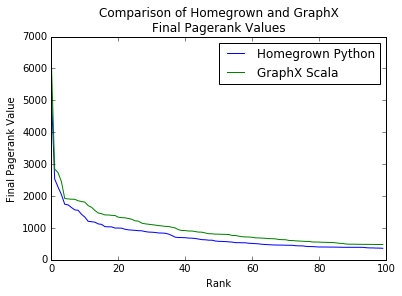

In [31]:
plt.plot(python_results, label="Homegrown Python")
plt.plot(scala_results, label="GraphX Scala")
plt.legend()
plt.title("Comparison of Homegrown and GraphX\nFinal Pagerank Values")
plt.xlabel("Rank")
plt.ylabel("Final Pagerank Value")